In [1]:
import numpy as np
import qiskit.pulse as pulse
import qiskit.circuit as circuit
from qiskit.providers.tergite import Tergite
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging
from qiskit.providers.jobstatus import JobStatus
import tqcsf.file
import time

In [2]:
chalmers = Tergite.get_provider()
backend = chalmers.get_backend("Nov7")
backend.set_options(shots=1500)
print(f"Loaded Tergite backend {backend.name}")

Loaded Tergite backend Nov7


In [3]:
# Lefty's calibration (2022-10-25)
q1 = {  #'freq_01': '3749584708.1745853',
    "freq_01": "3747793170",
    "init_duration": "0.0003",
    "mw_amp180": "0.1573217116739378",
    "ro_acq_delay": "3e-07",
    "ro_acq_integration_time": "2.5e-06",
    "ro_freq": "6741583902.617835",
    "ro_pulse_amp": "0.00125",
    "ro_pulse_delay": "4e-09",
    "ro_pulse_duration": "3e-06",
}
q2 = {  #'freq_01': '3305659156.82418',
    "freq_01": "3304105194",
    "init_duration": "0.0003",
    "mw_amp180": "0.162628951043618",
    "ro_acq_delay": "3e-07",
    "ro_acq_integration_time": "2.5e-06",
    "ro_freq": "6478209424.33459",
    "ro_pulse_amp": "0.00500",
    "ro_pulse_delay": "4e-09",
    "ro_pulse_duration": "3e-06",
}
q3 = {  #'freq_01': '3887617514.743307',
    "freq_01": "3886156251",
    "init_duration": "0.0003",
    "mw_amp180": "0.14470129746405025",
    "ro_acq_delay": "3e-07",
    "ro_acq_integration_time": "2.5e-06",
    "ro_freq": "7052143960.795639",
    "ro_pulse_amp": "0.00500",
    "ro_pulse_delay": "4e-09",
    "ro_pulse_duration": "3e-06",
}
q4 = {  #'freq_01': '3254451288.5693564',
    "freq_01": "3252921704",
    "init_duration": "0.0003",
    "mw_amp180": "0.15721634788675287",
    "ro_acq_delay": "3e-07",
    "ro_acq_integration_time": "2.5e-06",
    "ro_freq": "6578988854.977489",
    "ro_pulse_amp": "0.00150",
    "ro_pulse_delay": "4e-09",
    "ro_pulse_duration": "3e-06",
}
q5 = {  #'freq_01': '3983036942.3408036', # excitation freq
    "freq_01": "3981583792",
    "init_duration": "0.0003",
    "mw_amp180": "0.15418024803095376",  # convert to rabi freq
    "ro_acq_delay": "3e-07",  # tof
    "ro_acq_integration_time": "2.5e-06",  # integration time
    "ro_freq": "6850488290.799288",  # frequency of resonator
    "ro_pulse_amp": "0.00150",  # readout pulse amplitude
    "ro_pulse_delay": "4e-09",
    "ro_pulse_duration": "3e-06",
}  # readout pulse duration

In [4]:
qbs = (q1, q2, q3, q4, q5)

In [5]:
def schedule(
    *,
    index: int,
    exc_freq_Hz: float,
    exc_amp_V: float,
    ro_freq_Hz: float,
    ro_amp_V: float,
    reset_ns: int = 300 * 1000,
    exc_dur_ns: int = 100,
    ro_dur_ns: int = 3000,
    ro_tof_ns: int = 300,
    ro_integration_time_ns: int = 2500
):
    param_sched = pulse.ScheduleBlock()

    # delay 40 µs
    param_sched += pulse.Delay(reset_ns, channel=backend.drive_channel(index))
    param_sched += pulse.Delay(reset_ns, channel=backend.measure_channel(index))
    param_sched += pulse.Delay(reset_ns, channel=backend.acquire_channel(index))

    param_sched += pulse.SetFrequency(exc_freq_Hz, backend.drive_channel(index))
    param_sched += pulse.Play(
        pulse.Gaussian(
            exc_dur_ns,
            amp=exc_amp_V,
            sigma=exc_dur_ns / 4,
        ),
        channel=backend.drive_channel(index),
    )

    # dont measure while exciting
    param_sched += pulse.Delay(exc_dur_ns, backend.measure_channel(index))
    param_sched += pulse.Delay(exc_dur_ns, backend.acquire_channel(index))

    param_sched += pulse.SetFrequency(ro_freq_Hz, backend.measure_channel(index))
    param_sched += pulse.Play(
        pulse.Constant(ro_dur_ns, ro_amp_V), channel=backend.measure_channel(index)
    )

    # time of flight 300ns
    param_sched += pulse.Delay(ro_tof_ns, backend.acquire_channel(index))

    # integration window 2.5 µs
    param_sched += pulse.Acquire(
        duration=ro_integration_time_ns,
        channel=backend.acquire_channel(index),
        mem_slot=backend.memory_slot(index),
    )

    return param_sched

In [6]:
index = 4
sweepdef_V = np.linspace(0, 0.1573217117, 50)

In [7]:
sweep = [
    schedule(
        index=index,
        exc_freq_Hz=qbs[index]["freq_01"],
        exc_amp_V=amp,
        ro_freq_Hz=qbs[index]["ro_freq"],
        ro_amp_V=qbs[index]["ro_pulse_amp"],
    )
    for amp in sweepdef_V
]
print("Sweep length:", len(sweep))

Sweep length: 50


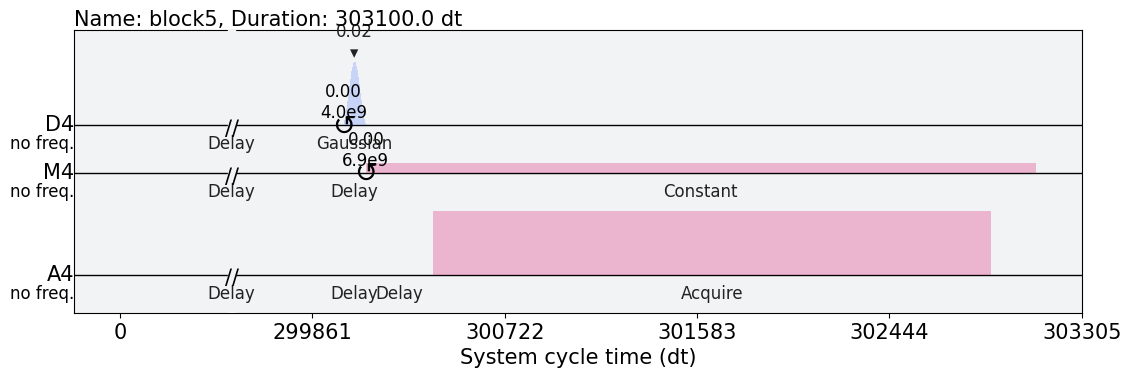

In [8]:
sweep[5].draw(style=IQXDebugging())

In [9]:
sweep_header = {
    "sweep": {
        "serial_order": ("x0",),
        "parameters": {
            "x0": {
                "long_name": "Amplitude of drive pulse",
                "unit": "V",
                "slots": {index: sweepdef_V},
            }
        },
    }
}
job = backend.run(sweep, meas_level=1, qobj_header=sweep_header)

Tergite: Job has been successfully submitted


In [10]:
# wait for job to complete
while job.status() != JobStatus.DONE:
    time.sleep(1)

In [11]:
# fetch storage file from BCC
sf = tqcsf.file.StorageFile(job.logfile, mode="r")
vars(sf)

{'mode': 'r',
 'file': <HDF5 file "5a6302f3-1b31-4f27-bcdc-a0cff4ab2b16.hdf5" (mode r)>,
 'tuid': '20221027-154533-490-6429d8',
 'meas_return': <MeasRet.AVERAGED: 1>,
 'meas_level': <MeasLvl.INTEGRATED: 1>,
 'meas_return_cols': 1,
 'job_id': '5a6302f3-1b31-4f27-bcdc-a0cff4ab2b16',
 'local': False,
 'header': <HDF5 group "/header" (1 members)>,
 'experiments': <HDF5 group "/experiments" (50 members)>}

In [12]:
# parse to xarray dataset, only possible for sweeps
ds = sf.as_xarray()
ds

20221027-154533-490-6429d8:   0%|          | 0/50 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:       (x0/slot~4: 50)
Coordinates:
  * x0/slot~4     (x0/slot~4) float64 0.0 0.003211 0.006421 ... 0.1541 0.1573
Data variables:
    slot~4/acq~0  (x0/slot~4) complex128 (-0.0034967792867611138+0.0015229463...
Attributes:
    job_id:            5a6302f3-1b31-4f27-bcdc-a0cff4ab2b16
    meas_level:        1
    meas_return:       1
    meas_return_cols:  1
    tuid:              20221027-154533-490-6429d8

<IPython.core.display.Javascript object>


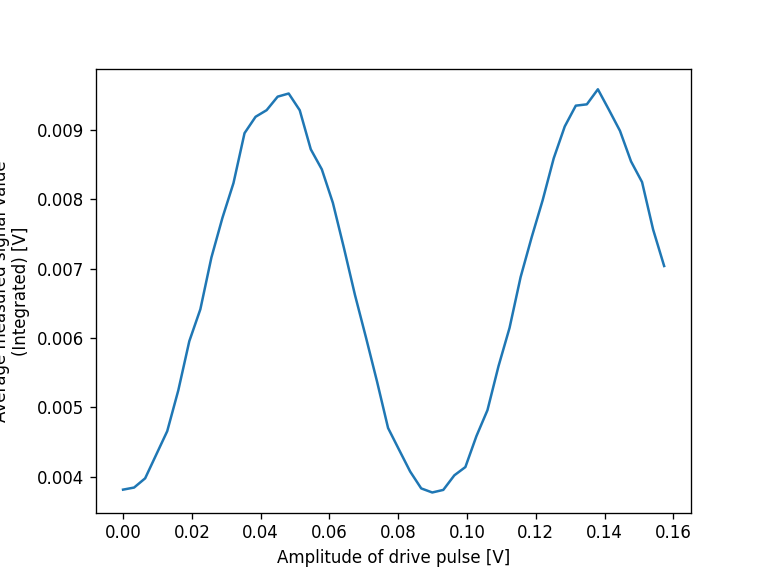

In [13]:
%matplotlib notebook
np.abs(ds[f"slot~{index}/acq~0"]).plot()